# Problem Setting: Representation Learning.

This notebook demonstrates that the Deep Boltzmann Machines(DBM) can learn images and reconstruct its. Image dataset for this demo is the MNIST. The code of this notebook is written on the premise that the MNIST images are divided and arranged in directories for each label beforehand.

## Problem Solution: Deep Boltzmann Machines(DBM).

As is well known, DBM is composed of layers of RBMs stacked on top of each other(Salakhutdinov, R., & Hinton, G. E. 2009). This model is a structural expansion of Deep Belief Networks(DBN), which is known as one of the earliest models of Deep Learning(Le Roux, N., & Bengio, Y. 2008). Like RBM, DBN places nodes in layers. However, only the uppermost layer is composed of undirected edges, and the other consists of directed edges.

According to graph theory, the structure of RBM corresponds to a complete bipartite graph which is a special kind of bipartite graph where every node in the visible layer is connected to every node in the hidden layer. Based on statistical mechanics and thermodynamics(Ackley, D. H., Hinton, G. E., & Sejnowski, T. J. 1985), the state of this structure can be reflected by the energy function.

In relation to RBM, the Contrastive Divergence(CD) is a method for approximation of the gradients of the log-likelihood(Hinton, G. E. 2002).This algorithm draws a distinction between a positive phase and a negative phase. Conceptually, the positive phase is to the negative phase what waking is to sleeping.

The procedure of this method is similar to Markov Chain Monte Carlo method(MCMC). However, unlike MCMC, the visbile variables to be set first in visible layer is not randomly initialized but the observed data points in training dataset are set to the first visbile variables. And, like Gibbs sampler, drawing samples from hidden variables and visible variables is repeated k times. Empirically (and surprisingly), `k` is considered to be `1`.

As a simple example, this notebook attempts to train a sample sampled from a Gaussian distribution.

### Modeling and Implementation.

Firstly, import Python modules for building the Deep Boltzmann Machines.

In [1]:
from accelbrainbase.noiseabledata._mxnet.gauss_noise import GaussNoise
from accelbrainbase.observabledata._mxnet.restrictedboltzmannmachines.deep_boltzmann_machines import DeepBoltzmannMachines
from accelbrainbase.observabledata._mxnet.restricted_boltzmann_machines import RestrictedBoltzmannMachines
from accelbrainbase.computableloss._mxnet.l2_norm_loss import L2NormLoss
from accelbrainbase.extractabledata._mxnet.image_extractor import ImageExtractor
from accelbrainbase.iteratabledata._mxnet.unlabeled_image_iterator import UnlabeledImageIterator

In [2]:
import mxnet as mx
import mxnet.ndarray as nd
import numpy as np
import pandas as pd

If you want to observe the learning log, set `getLogger`.

In [3]:
from logging import getLogger, StreamHandler, NullHandler, DEBUG, ERROR

logger = getLogger("accelbrainbase")
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)

Build and initialize `ImageExtractor`, specifying parameters such as image size.

In [4]:
image_extractor = ImageExtractor(
    # `int` of image width.
    width=28,
    # `int` of image height.
    height=28,
    # `int` of image channel.
    channel=1,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu()
)

Build and initialize `UnlabeledImageIterator`, delegating `image_extractor` and specifying parameters such as file path to image files.

In [5]:
unlabeled_image_iterator = UnlabeledImageIterator(
    # is-a `ImageExtractor`.
    image_extractor=image_extractor,
    # `list` of paths to image files in learning.
    dir_list=[
        "../../../../../Downloads/digit-recognizer/train/0/", 
        "../../../../../Downloads/digit-recognizer/train/1/", 
        "../../../../../Downloads/digit-recognizer/train/2/", 
        "../../../../../Downloads/digit-recognizer/train/3/", 
        "../../../../../Downloads/digit-recognizer/train/4/", 
        "../../../../../Downloads/digit-recognizer/train/5/", 
        "../../../../../Downloads/digit-recognizer/train/6/", 
        "../../../../../Downloads/digit-recognizer/train/7/", 
        "../../../../../Downloads/digit-recognizer/train/8/", 
        "../../../../../Downloads/digit-recognizer/train/9/", 
    ],
    # `list` of paths to image files in test.
    test_dir_list=[
        "../../../../../Downloads/digit-recognizer/test/0/", 
        "../../../../../Downloads/digit-recognizer/test/1/", 
        "../../../../../Downloads/digit-recognizer/test/2/", 
        "../../../../../Downloads/digit-recognizer/test/3/", 
        "../../../../../Downloads/digit-recognizer/test/4/", 
        "../../../../../Downloads/digit-recognizer/test/5/", 
        "../../../../../Downloads/digit-recognizer/test/6/", 
        "../../../../../Downloads/digit-recognizer/test/7/", 
        "../../../../../Downloads/digit-recognizer/test/8/", 
        "../../../../../Downloads/digit-recognizer/test/9/", 
    ],
    # `int` of epochs.
    epochs=100,
    # `int` of batch size.
    batch_size=100,
    # How to normalize pixel values of images.
    # - `z_score`: Z-Score normalization.
    # - `min_max`: Min-max normalization.
    # - others : This class will not normalize the data.
    norm_mode="min_max",
    # `float` of scaling factor for data.
    scale=1.0,
    # is-a `NoiseableData`.
    noiseable_data=GaussNoise(sigma=1e-03, mu=0.0),
)

Build and initialize loss function.

In [6]:
computable_loss = L2NormLoss()

Build and initialize `RestrictedBoltzmannMachines`s.

In [7]:
RBM_1 = RestrictedBoltzmannMachines(
    # is-a `ComputableLoss`.
    computable_loss=computable_loss,
    # `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in visible layer.
    visible_activation="sigmoid",
    # `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in hidden layer.
    hidden_activation="sigmoid",
    # `int` of dimension in visible layer.
    visible_dim=784,
    # `int` of dimension in hidden layer.
    hidden_dim=100,
    # `float` of dropout rate in visible layer.
    visible_dropout_rate=0.0,
    # `float` of dropout rate in hidden layer.
    hidden_dropout_rate=0.0,
    # `gluon.nn.BatchNorm` in visible layer.
    visible_batch_norm=None,
    # `gluon.nn.BatchNorm` in hidden layer.
    hidden_batch_norm=None,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

RBM_2 = RestrictedBoltzmannMachines(
    # is-a `ComputableLoss`.
    computable_loss=computable_loss,
    # `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in visible layer.
    visible_activation="sigmoid",
    # `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in hidden layer.
    hidden_activation="sigmoid",
    # `int` of dimension in visible layer.
    visible_dim=100,
    # `int` of dimension in hidden layer.
    hidden_dim=100,
    # `float` of dropout rate in visible layer.
    visible_dropout_rate=0.0,
    # `float` of dropout rate in hidden layer.
    hidden_dropout_rate=0.0,
    # `gluon.nn.BatchNorm` in visible layer.
    visible_batch_norm=None,
    # `gluon.nn.BatchNorm` in hidden layer.
    hidden_batch_norm=None,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

RBM_3 = RestrictedBoltzmannMachines(
    # is-a `ComputableLoss`.
    computable_loss=computable_loss,
    # `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in visible layer.
    visible_activation="sigmoid",
    # `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in hidden layer.
    hidden_activation="sigmoid",
    # `int` of dimension in visible layer.
    visible_dim=100,
    # `int` of dimension in hidden layer.
    hidden_dim=784,
    # `float` of dropout rate in visible layer.
    visible_dropout_rate=0.0,
    # `float` of dropout rate in hidden layer.
    hidden_dropout_rate=0.0,
    # `gluon.nn.BatchNorm` in visible layer.
    visible_batch_norm=None,
    # `gluon.nn.BatchNorm` in hidden layer.
    hidden_batch_norm=None,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Build and initialize `DeepBoltzmannMachines`, delegating `list` of `RestrictedBoltzmannMachines`s.

In [8]:
DBM = DeepBoltzmannMachines(
    # is-a `ComputableLoss`.
    computable_loss=computable_loss,
    # `list` of `RestrictedBoltzmannMachines`s.
    rbm_list=[
        RBM_1,
        RBM_2,
        RBM_3
    ],
    # is-a `mxnet.initializer` for parameters of model. If `None`, it is drawing from the Xavier distribution.
    initializer=None,
    # `str` of name of optimizer.
    optimizer_name="Adam",
    # `float` of learning rate.
    learning_rate=1e-03,
    # `float` of attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=1.0,
    # `int` of attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
)

Start learning.

In [9]:
DBM.learn(unlabeled_image_iterator)

Epoch: 1 Train loss: 0.23712568 Test loss: 0.28548038
Epoch: 2 Train loss: 0.2644606 Test loss: 0.27037993
Epoch: 3 Train loss: 0.19424205 Test loss: 0.27376124
Epoch: 4 Train loss: 0.26420018 Test loss: 0.26027328
Epoch: 5 Train loss: 0.24780482 Test loss: 0.2643246
Epoch: 6 Train loss: 0.11719212 Test loss: 0.23564124
Epoch: 7 Train loss: 0.2227943 Test loss: 0.2288083
Epoch: 8 Train loss: 0.22564921 Test loss: 0.23724014
Epoch: 9 Train loss: 0.2279533 Test loss: 0.18158247
Epoch: 10 Train loss: 0.28253907 Test loss: 0.20196113
Epoch: 11 Train loss: 0.18468551 Test loss: 0.22647284
Epoch: 12 Train loss: 0.1841266 Test loss: 0.23719752
Epoch: 13 Train loss: 0.20323963 Test loss: 0.17166145
Epoch: 14 Train loss: 0.22324978 Test loss: 0.2317762
Epoch: 15 Train loss: 0.21135725 Test loss: 0.20215335
Epoch: 16 Train loss: 0.12235842 Test loss: 0.21424076
Epoch: 17 Train loss: 0.09355081 Test loss: 0.21862277
Epoch: 18 Train loss: 0.27117935 Test loss: 0.1665641
Epoch: 19 Train loss: 0.155

Visualize reconstruction losses.

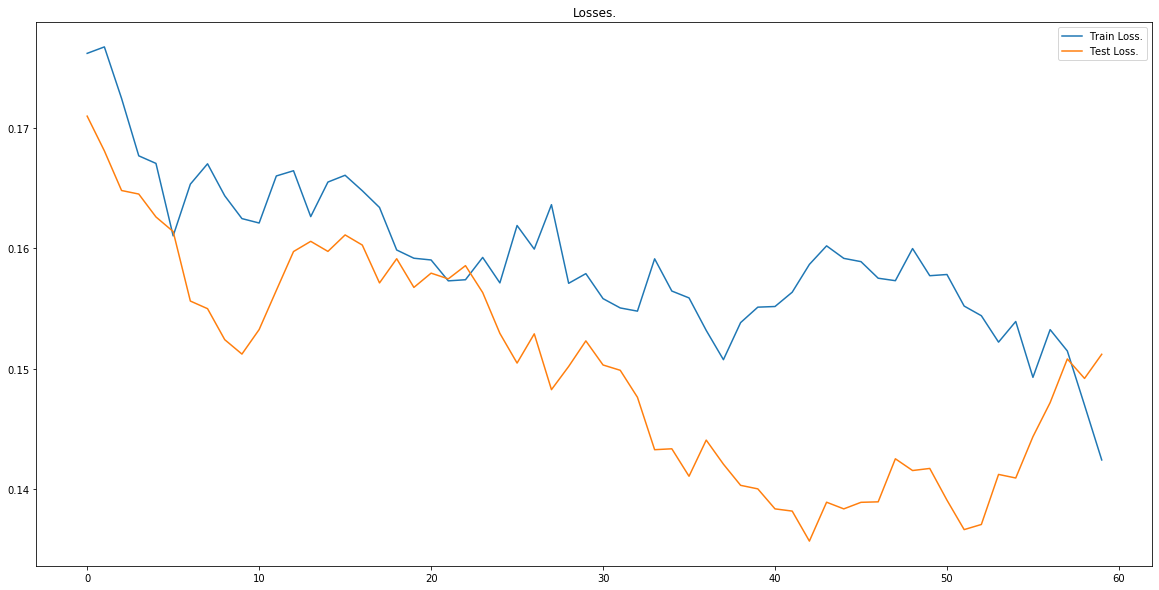

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

def moving_avg(arr, window=20):
    return np.convolve(arr, np.ones(window) / window, mode='same')[window:-window]

plt.figure(figsize=(20, 10))
plt.plot(moving_avg(DBM.loss_arr[:, 0]), label="Train Loss.")
plt.plot(moving_avg(DBM.loss_arr[:, 1]), label="Test Loss.")
plt.legend()
plt.title("Losses.")
plt.show()

In [17]:
DBM.learn(unlabeled_image_iterator)

Epoch: 1 Train loss: 0.14734106 Test loss: 0.15750249
Epoch: 2 Train loss: 0.12040228 Test loss: 0.1113105
Epoch: 3 Train loss: 0.11756975 Test loss: 0.13085786
Epoch: 4 Train loss: 0.07879055 Test loss: 0.21481752
Epoch: 5 Train loss: 0.13754286 Test loss: 0.1549908
Epoch: 6 Train loss: 0.1781121 Test loss: 0.16853596
Epoch: 7 Train loss: 0.15601695 Test loss: 0.1482232
Epoch: 8 Train loss: 0.12698197 Test loss: 0.11841481
Epoch: 9 Train loss: 0.21623744 Test loss: 0.14217116
Epoch: 10 Train loss: 0.1644899 Test loss: 0.1646797
Epoch: 11 Train loss: 0.08040532 Test loss: 0.15116169
Epoch: 12 Train loss: 0.14210732 Test loss: 0.15813692
Epoch: 13 Train loss: 0.15825446 Test loss: 0.093953356
Epoch: 14 Train loss: 0.18685892 Test loss: 0.137339
Epoch: 15 Train loss: 0.109953724 Test loss: 0.08594536
Epoch: 16 Train loss: 0.12075836 Test loss: 0.08848693
Epoch: 17 Train loss: 0.13077772 Test loss: 0.1389354
Epoch: 18 Train loss: 0.12220304 Test loss: 0.12925574
Epoch: 19 Train loss: 0.16

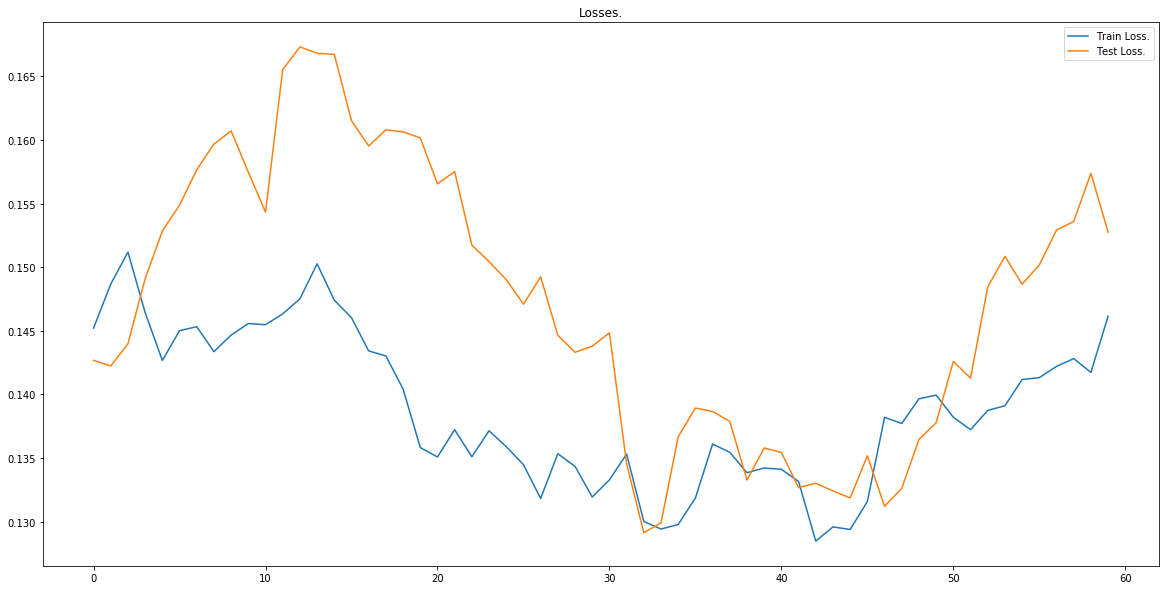

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

def moving_avg(arr, window=20):
    return np.convolve(arr, np.ones(window) / window, mode='same')[window:-window]

plt.figure(figsize=(20, 10))
plt.plot(moving_avg(DBM.loss_arr[:, 0]), label="Train Loss.")
plt.plot(moving_avg(DBM.loss_arr[:, 1]), label="Test Loss.")
plt.legend()
plt.title("Losses.")
plt.show()

Let the model observe the test data and extract the feature points to see.

In [24]:
test_arr = None
for _, _, _test_arr, _ in unlabeled_image_iterator.generate_learned_samples():
    test_arr = _test_arr
    break

In [25]:
decoded_arr = DBM.inference(test_arr)

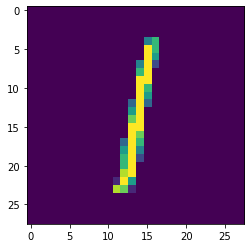

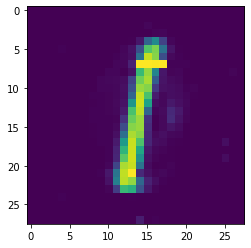

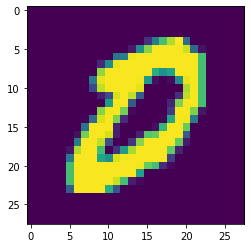

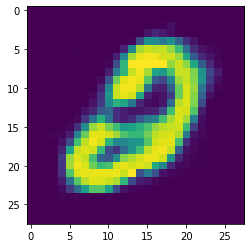

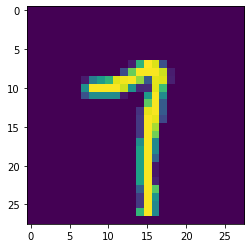

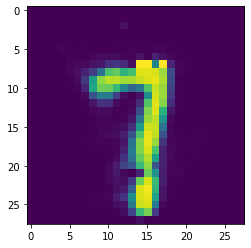

In [26]:
for i in range(3):
    plt.imshow(test_arr[i].reshape((28, 28)).asnumpy())
    plt.show()
    plt.imshow(decoded_arr[i].reshape((28, 28)).asnumpy())
    plt.show()

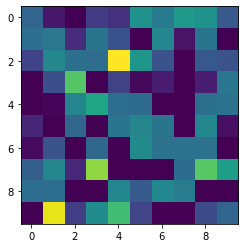

In [48]:
plt.imshow(nd.mean(DBM.rbm_list[0].feature_points_arr, axis=0).asnumpy().reshape((10, 10)))
plt.show()

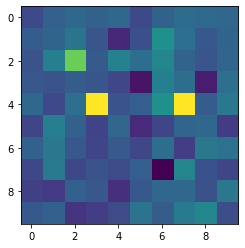

In [47]:
plt.imshow(nd.mean(DBM.rbm_list[1].feature_points_arr, axis=0).asnumpy().reshape((10, 10)))
plt.show()

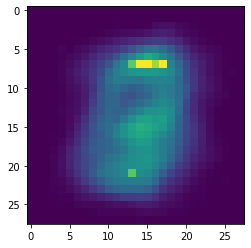

In [46]:
plt.imshow(nd.mean(DBM.rbm_list[2].feature_points_arr, axis=0).asnumpy().reshape((28, 28)))
plt.show()

In [49]:
DBM.extract_learned_dict()

{'restrictedboltzmannmachines0_dense0_weight': 
 [[-0.8467379  -1.1662006  -0.37426433 ...  0.14026612 -0.43680114
    0.00942103]
  [-0.97276634  0.40229562  0.13417561 ... -1.0715362  -0.5130103
   -2.7741647 ]
  [ 0.14675698  0.19868712  0.22872351 ...  0.16871443  0.21229267
    0.18029523]
  ...
  [ 0.10233703  0.26259118  0.12708797 ...  0.06351527  0.18326145
    0.20739897]
  [-0.15890056 -0.79006803 -0.35147446 ... -0.31819132 -0.49117127
    0.6344871 ]
  [-0.3723512  -0.41455457 -0.20042236 ... -0.8325488  -0.27567053
   -0.575802  ]]
 <NDArray 100x784 @gpu(0)>,
 'restrictedboltzmannmachines0_dense0_bias': 
 [ 6.12353742e-01  4.57443190e+00 -2.66492456e-01 -4.22313511e-01
  -3.12593818e+00 -3.77895355e-01 -6.46497846e-01  1.62141633e+00
   1.96441495e+00 -1.06046057e+00  1.14317012e+00  1.31566656e+00
  -3.00045013e+00  1.13048248e+01 -2.67165852e+00  2.89675202e-02
   1.08689618e+00 -5.61286509e-02 -1.98629886e-01  1.46034276e+00
   6.97101176e-01  6.10548973e+00  3.7469723

## For ML Ops.

This model inherits [HybridBlock](https://gluon.mxnet.io/chapter07_distributed-learning/hybridize.html) from [mxnet.gluon](https://mxnet.incubator.apache.org/api/python/docs/api/gluon/index.html). Functions for common ML Ops such as saving and loading parameters are provided by [HybridBlock](https://mxnet.apache.org/api/python/docs/api/gluon/hybrid_block.html).

# References

- Ackley, D. H., Hinton, G. E., & Sejnowski, T. J. (1985). A learning algorithm for Boltzmann machines. Cognitive science, 9(1), 147-169.
- Hinton, G. E. (2002). Training products of experts by minimizing contrastive divergence. Neural computation, 14(8), 1771-1800.
- Le Roux, N., & Bengio, Y. (2008). Representational power of restricted Boltzmann machines and deep belief networks. Neural computation, 20(6), 1631-1649.
- Salakhutdinov, R., & Hinton, G. E. (2009). Deep boltzmann machines. InInternational conference on artificial intelligence and statistics (pp. 448-455).